In [2]:
# ===============================
#         REQUIRED LIBRARIES
# ===============================
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# ===============================
#         LOAD DATA
# ===============================
df = pd.read_csv("Autism-prediction/train (1).csv")  # Change to your filename
df.drop(columns=['ID'], inplace=True)
df['relation'] = df['relation'].replace('?', 'Unknown')

X = df.drop(columns=['Class/ASD'])
y = df['Class/ASD']

# ===============================
#         FEATURE GROUPS
# ===============================
score_features = [col for col in X.columns if 'Score' in col]
num_features = ['age', 'result']
cat_features = list(set(X.columns) - set(score_features) - set(num_features))

# ===============================
#       COLUMN TRANSFORMER
# ===============================
preprocessor = ColumnTransformer(transformers=[
    ('num', RobustScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
], remainder='passthrough')

# ===============================
#         BASE MODELS
# ===============================
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0,
                    colsample_bytree=0.7, learning_rate=0.01, max_depth=7,
                    n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.7)

lgbm = LGBMClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth=7,
                      n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.7)

catboost = CatBoostClassifier(verbose=0, learning_rate=0.01, depth=7, iterations=200)

# ===============================
#     STACKING CLASSIFIER
# ===============================
stacked_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('cat', catboost)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True
)

# ===============================
#     FULL PIPELINE + CV
# ===============================
pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),
    ('model', stacked_model)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, roc_scores = [], []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    y_prob = pipeline.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_prob)

    acc_scores.append(acc)
    roc_scores.append(roc)

    print(f"Fold {fold} - Accuracy: {acc:.4f}, ROC AUC: {roc:.4f}")

print("\nCross-Validation Summary")
print("=========================")
print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
print(f"Mean ROC AUC: {np.mean(roc_scores):.4f}")


[LightGBM] [Info] Number of positive: 435, number of negative: 333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.566406 -> initscore=0.267204
[LightGBM] [Info] Start training from score 0.267204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 185, number of negative: 615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231250 -> initscore=-1.201266
[LightGBM] [Info] Start training from score -1.201266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

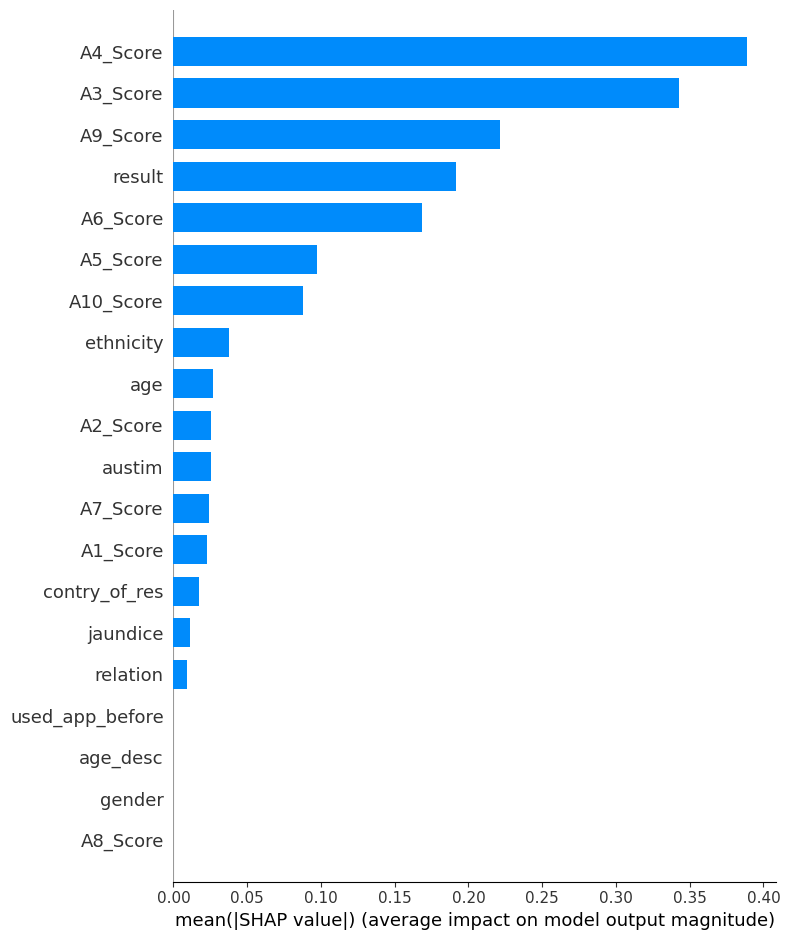


Top 15 SHAP Features:
['A4_Score', 'A3_Score', 'A9_Score', 'result', 'A6_Score', 'A5_Score', 'A10_Score', 'ethnicity', 'age', 'A2_Score', 'austim', 'A7_Score', 'A1_Score', 'contry_of_res', 'jaundice']


In [6]:
# ==============================
#        SHAP Feature Selection
# ==============================

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

# Load your data
df = pd.read_csv("Autism-prediction/train (1).csv")
df.drop(columns=['ID'], inplace=True)
df['relation'] = df['relation'].replace('?', 'Unknown')

X = df.drop(columns=['Class/ASD'])
y = df['Class/ASD']

# Feature groups
score_features = [col for col in X.columns if 'Score' in col]
num_features = ['age', 'result']
cat_features = list(set(X.columns) - set(score_features) - set(num_features))

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', RobustScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
], remainder='passthrough')

X_processed = preprocessor.fit_transform(X)

# Train LightGBM model
model = LGBMClassifier(
    colsample_bytree=0.7, learning_rate=0.01, max_depth=7,
    n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.7
)
model.fit(X_processed, y)

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_processed)

# Get feature names after preprocessing
processed_feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out(num_features).tolist()
    + preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features).tolist()
    + score_features
)

# SHAP summary plot
shap.summary_plot(shap_values, X_processed, feature_names=processed_feature_names, plot_type="bar")

# Calculate mean SHAP values
mean_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': processed_feature_names,
    'mean_abs_shap': mean_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# Select top 15 features
top_features = shap_df['feature'].head(15).tolist()

print("\nTop 15 SHAP Features:")
print(top_features)


In [8]:
# ================================
#     OPTUNA TUNING FOR XGBOOST
# ================================

import pandas as pd
import numpy as np
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import make_scorer, roc_auc_score

# Load data
df = pd.read_csv("Autism-prediction/train (1).csv")
df.drop(columns=['ID'], inplace=True)
df['relation'] = df['relation'].replace('?', 'Unknown')

# Top 15 SHAP-selected features
top_features = ['A4_Score', 'A3_Score', 'A9_Score', 'result', 'A6_Score', 'A5_Score',
                'A10_Score', 'ethnicity', 'age', 'A2_Score', 'austim',
                'A7_Score', 'A1_Score', 'contry_of_res', 'jaundice']

X = df[top_features]
y = df['Class/ASD']

# Feature groups
num_features = ['age', 'result']
cat_features = ['ethnicity', 'austim', 'contry_of_res', 'jaundice']
score_features = list(set(top_features) - set(num_features) - set(cat_features))

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
], remainder='passthrough')


# Define objective function for Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0)
    }

    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **params)

    pipeline = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smoteenn', SMOTEENN(random_state=42)),
        ('model', model)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=make_scorer(roc_auc_score))

    return scores.mean()


# Run Optuna Study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)

# Best result
print("\nBest ROC AUC:", study.best_value)
print("Best Parameters:\n", study.best_params)


[I 2025-06-17 19:45:55,300] A new study created in memory with name: no-name-3302d29d-c66a-421a-a6e5-9cce4926e457


[I 2025-06-17 19:45:57,057] Trial 0 finished with value: 0.845484508899143 and parameters: {'max_depth': 9, 'learning_rate': 0.02477621016320252, 'n_estimators': 414, 'colsample_bytree': 0.7769392527913038, 'subsample': 0.9166209145129567, 'reg_alpha': 1.1789646029798662, 'reg_lambda': 7.242608608890763}. Best is trial 0 with value: 0.845484508899143.
[I 2025-06-17 19:45:57,556] Trial 1 finished with value: 0.844407822456603 and parameters: {'max_depth': 7, 'learning_rate': 0.08004701844667385, 'n_estimators': 142, 'colsample_bytree': 0.675822437754672, 'subsample': 0.8816425183807288, 'reg_alpha': 1.9130158110683904, 'reg_lambda': 9.268833481279414}. Best is trial 0 with value: 0.845484508899143.
[I 2025-06-17 19:45:58,156] Trial 2 finished with value: 0.8411557899362776 and parameters: {'max_depth': 3, 'learning_rate': 0.0901906257374797, 'n_estimators': 337, 'colsample_bytree': 0.7310786477058855, 'subsample': 0.5365905590704798, 'reg_alpha': 3.2492311958823867, 'reg_lambda': 1.2101


Best ROC AUC: 0.8581630410898704
Best Parameters:
 {'max_depth': 8, 'learning_rate': 0.006934408227980577, 'n_estimators': 191, 'colsample_bytree': 0.550678576601557, 'subsample': 0.5007655903204851, 'reg_alpha': 3.988215628062359, 'reg_lambda': 1.8676699348079597}


In [15]:
# ===============================================
#   Final Boosted Stacking Ensemble with XGBoost
# ===============================================

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

# Load and preprocess data
df = pd.read_csv("Autism-prediction/train (1).csv")
df.drop(columns=['ID'], inplace=True)
df['relation'] = df['relation'].replace('?', 'Unknown')

# SHAP-selected features
top_features = ['A4_Score', 'A3_Score', 'A9_Score', 'result', 'A6_Score', 'A5_Score',
                'A10_Score', 'ethnicity', 'age', 'A2_Score', 'austim', 'A7_Score',
                'A1_Score', 'contry_of_res', 'jaundice']

X = df[top_features]
y = df['Class/ASD']

# Feature groups
num_features = ['age', 'result']
cat_features = ['ethnicity', 'austim', 'contry_of_res', 'jaundice']
score_features = list(set(top_features) - set(num_features) - set(cat_features))

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
], remainder='passthrough')

# Base Models
rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
lgbm = LGBMClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth=7,
                      n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.7, random_state=42)

xgb_base = XGBClassifier(
    max_depth=8,
    learning_rate=0.006934408227980577,
    n_estimators=191,
    colsample_bytree=0.550678576601557,
    subsample=0.5007655903204851,
    reg_alpha=3.988215628062359,
    reg_lambda=1.8676699348079597,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Final Meta-model (same tuned XGBoost)
xgb_meta = XGBClassifier(
    max_depth=11,
    learning_rate=0.006934408227980577,
    n_estimators=1000,
    colsample_bytree=0.550678576601557,
    subsample=0.5007655903204851,
    reg_alpha=3.988215628062359,
    reg_lambda=1.8676699348079597,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Stacking classifier
stacked_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('lgbm', lgbm),
        ('xgb', xgb_base)
    ],
    final_estimator=xgb_meta,
    passthrough=True,
    n_jobs=-1
)

# Full pipeline with preprocessing + SMOTEENN
pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),
    ('stack', stacked_model)
])

# Stratified 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
roc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

# Results
print("Cross-Validation Summary")
print("=========================")
print(f"Mean Accuracy: {acc_scores.mean():.4f}")
print(f"Mean ROC AUC:  {roc_scores.mean():.4f}")


Cross-Validation Summary
Mean Accuracy: 0.8550
Mean ROC AUC:  0.9115


In [3]:
# ================================================
# FINAL ENHANCED STACKING MODEL (v2 with FE)
# ================================================

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, roc_auc_score

# Load and preprocess data
df = pd.read_csv("Autism-prediction/train (1).csv")
df.drop(columns=['ID'], inplace=True)
df['relation'] = df['relation'].replace('?', 'Unknown')

# Engineered features
df['Total_Score'] = df[[f'A{i}_Score' for i in range(1, 11)]].sum(axis=1)
df['Age_Result_Interaction'] = df['age'] * df['result']
df['A4_A9_Interaction'] = df['A4_Score'] * df['A9_Score']

# Final top 20 SHAP + engineered features
top_features = ['A4_Score', 'A3_Score', 'A9_Score', 'result', 'A6_Score', 'A5_Score',
                'A10_Score', 'ethnicity', 'age', 'A2_Score', 'austim', 'A7_Score',
                'A1_Score', 'contry_of_res', 'jaundice', 'A8_Score', 'gender', 'relation',
                'used_app_before', 'Total_Score', 'Age_Result_Interaction', 'A4_A9_Interaction']


X = df[top_features]
y = df['Class/ASD']

# Identify numeric & categorical
num_features = ['age', 'result', 'Total_Score', 'Age_Result_Interaction', 'A4_A9_Interaction']
cat_features = ['ethnicity', 'austim', 'contry_of_res', 'jaundice', 'gender', 'relation', 'used_app_before']
# remaining are 0/1 SHAP scores — keep passthrough

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
], remainder='passthrough')

# Models (same tuned)
rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
lgbm = LGBMClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth=7,
                      n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.7, random_state=42)

xgb_base = XGBClassifier(
    max_depth=8,
    learning_rate=0.006934408227980577,
    n_estimators=300,
    colsample_bytree=0.550678576601557,
    subsample=0.5007655903204851,
    reg_alpha=3.988215628062359,
    reg_lambda=1.8676699348079597,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_meta = XGBClassifier(
    max_depth=8,
    learning_rate=0.006934408227980577,
    n_estimators=300,
    colsample_bytree=0.550678576601557,
    subsample=0.5007655903204851,
    reg_alpha=3.988215628062359,
    reg_lambda=1.8676699348079597,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Stacking
stacked_model = StackingClassifier(
    estimators=[('rf', rf), ('lgbm', lgbm), ('xgb', xgb_base)],
    final_estimator=xgb_meta,
    passthrough=True,
    n_jobs=-1
)

# Full Pipeline
pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),
    ('stack', stacked_model)
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
roc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

# Output
print("Cross-Validation Summary")
print("=========================")
print(f"Mean Accuracy: {acc_scores.mean():.4f}")
print(f"Mean ROC AUC:  {roc_scores.mean():.4f}")


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:15] WARNING: C:\actions-r

Cross-Validation Summary
Mean Accuracy: 0.8363
Mean ROC AUC:  0.8921


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:26:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Dataset shape: (800, 22)
Target distribution:
Class/ASD
0    615
1    185
Name: count, dtype: int64
Applying preprocessing...
Encoding features...
Selected features (23): ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result', 'AQ_Total', 'AQ_Category', 'Age_Group', 'Family_History', 'Had_Jaundice', 'Used_App', 'Self_Report', 'Gender_Male', 'AQ_Age_Interaction', 'Family_AQ_Interaction', 'Ethnicity_Grouped']
Training data shape: (800, 23)
Class distribution: {0.0: 615, 1.0: 185}
Initializing models...

MODEL EVALUATION RESULTS
Evaluating individual models...
  Evaluating lgbm...
    lgbm       - ROC AUC: 0.8672 (+/- 0.0260)
  Evaluating xgb...
    xgb        - ROC AUC: 0.8658 (+/- 0.0220)
  Evaluating catboost...
    catboost   - ROC AUC: 0.8753 (+/- 0.0132)
  Evaluating rf...
    rf         - ROC AUC: 0.8930 (+/- 0.0099)
  Evaluating ensemble...
    Ensemble   - ROC AUC: 0.8801 (+/- 0.0121)

Training fin

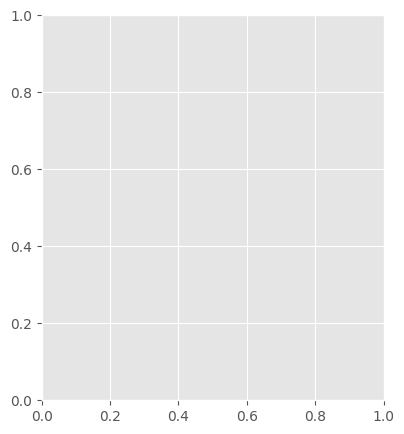

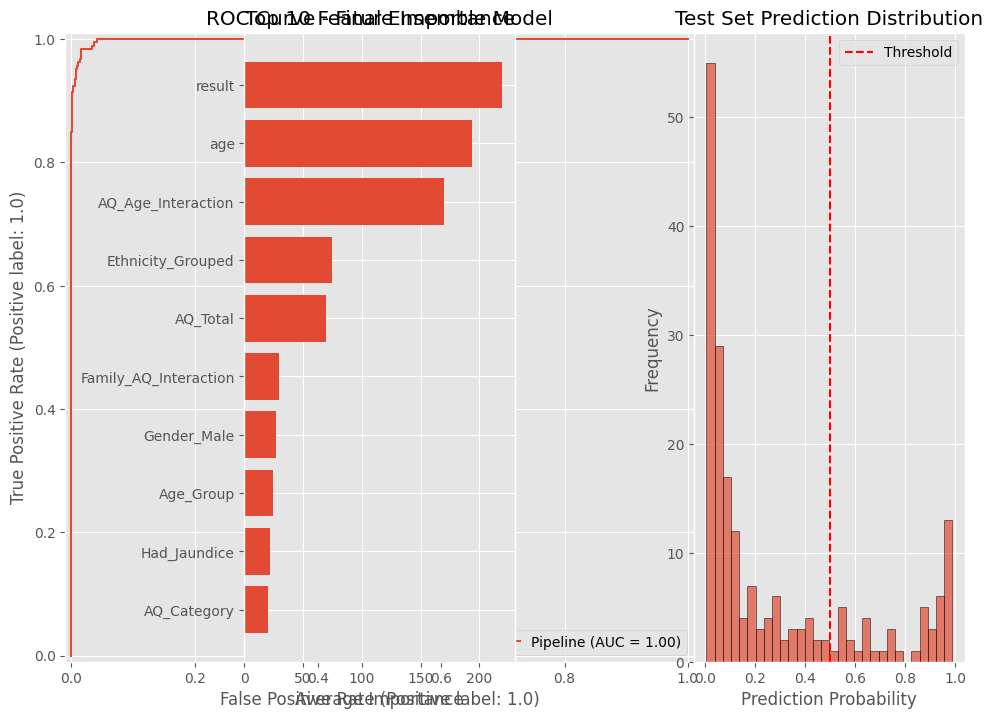


OPTIMIZATION IMPROVEMENTS
Key optimizations implemented:
1. Removed expensive grid search hyperparameter tuning
2. Reduced n_estimators from 300 to 200 for faster training
3. Reduced CV folds from 5 to 3 for faster evaluation
4. Pre-optimized model parameters based on common best practices
5. Added progress indicators and error handling
6. Simplified feature importance extraction
7. More efficient data loading and preprocessing


In [1]:
# ===============================
#         IMPORTS
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, confusion_matrix, classification_report
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]

# ===============================
#         LOAD DATA
# ===============================
# Update these paths to match your actual file locations
try:
    train_data = pd.read_csv('Autism-prediction/train (1).csv')  # Update path as needed
    test_data = pd.read_csv('Autism-prediction/test.csv')    # Update path as needed
except FileNotFoundError:
    # Try alternative paths
    try:
        train_data = pd.read_csv('train (1).csv')
        test_data = pd.read_csv('test.csv')
    except FileNotFoundError:
        print("Please update the file paths in the code to match your data location")
        print("Current working directory:", os.getcwd())
        raise

print("Dataset shape:", train_data.shape)
print("Target distribution:")
print(train_data['Class/ASD'].value_counts())

# ===============================
#     ENHANCED DATA PREPROCESSING
# ===============================
def advanced_preprocessing(train_df, test_df):
    """Optimized preprocessing function"""
    # Remove duplicates
    train_df = train_df.drop_duplicates()

    # Handle missing values and unknown entries
    for col in ['ethnicity', 'contry_of_res', 'relation']:
        if col in train_df.columns:
            train_df[col] = train_df[col].fillna('Unknown').replace('?', 'Unknown')
            test_df[col] = test_df[col].fillna('Unknown').replace('?', 'Unknown')

    # Clean ethnicity data
    if 'ethnicity' in train_df.columns:
        train_df['ethnicity'] = train_df['ethnicity'].str.strip().str.lower()
        test_df['ethnicity'] = test_df['ethnicity'].str.strip().str.lower()

    # Feature Engineering
    # 1. AQ Score (sum of A1-A10 scores)
    aq_cols = [f'A{i}_Score' for i in range(1, 11)]
    train_df['AQ_Total'] = train_df[aq_cols].sum(axis=1)
    test_df['AQ_Total'] = test_df[aq_cols].sum(axis=1)

    # 2. AQ Score categories
    train_df['AQ_Category'] = pd.cut(train_df['AQ_Total'],
                                   bins=[0, 3, 6, 10],
                                   labels=['Low', 'Medium', 'High'])
    test_df['AQ_Category'] = pd.cut(test_df['AQ_Total'],
                                  bins=[0, 3, 6, 10],
                                  labels=['Low', 'Medium', 'High'])

    # 3. Age groups
    train_df['Age_Group'] = pd.cut(train_df['age'],
                                 bins=[0, 20, 30, 40, 50, 100],
                                 labels=['Youth', 'Young_Adult', 'Adult', 'Middle_Age', 'Senior'])
    test_df['Age_Group'] = pd.cut(test_df['age'],
                                bins=[0, 20, 30, 40, 50, 100],
                                labels=['Youth', 'Young_Adult', 'Adult', 'Middle_Age', 'Senior'])

    # 4. Binary features
    binary_mappings = {
        'austim': 'Family_History',
        'jaundice': 'Had_Jaundice', 
        'used_app_before': 'Used_App'
    }
    
    for original_col, new_col in binary_mappings.items():
        if original_col in train_df.columns:
            train_df[new_col] = (train_df[original_col] == 'yes').astype(int)
            test_df[new_col] = (test_df[original_col] == 'yes').astype(int)

    # 5. Relation and gender features
    if 'relation' in train_df.columns:
        train_df['Self_Report'] = (train_df['relation'] == 'Self').astype(int)
        test_df['Self_Report'] = (test_df['relation'] == 'Self').astype(int)
    
    if 'gender' in train_df.columns:
        train_df['Gender_Male'] = (train_df['gender'] == 'm').astype(int)
        test_df['Gender_Male'] = (test_df['gender'] == 'm').astype(int)

    # 6. Interaction features
    train_df['AQ_Age_Interaction'] = train_df['AQ_Total'] * train_df['age']
    test_df['AQ_Age_Interaction'] = test_df['AQ_Total'] * test_df['age']

    if 'Family_History' in train_df.columns:
        train_df['Family_AQ_Interaction'] = train_df['Family_History'] * train_df['AQ_Total']
        test_df['Family_AQ_Interaction'] = test_df['Family_History'] * test_df['AQ_Total']

    # 7. Ethnicity grouping
    if 'ethnicity' in train_df.columns:
        ethnicity_mapping = {
            'white-european': 'European',
            'south asian': 'Asian',
            'asian': 'Asian',
            'middle eastern': 'Middle_Eastern',
            'black': 'Black',
            'hispanic': 'Hispanic',
            'latino': 'Hispanic',
            'others': 'Other',
            'unknown': 'Other'
        }
        train_df['Ethnicity_Grouped'] = train_df['ethnicity'].map(ethnicity_mapping).fillna('Other')
        test_df['Ethnicity_Grouped'] = test_df['ethnicity'].map(ethnicity_mapping).fillna('Other')

    return train_df, test_df

# Apply preprocessing
print("Applying preprocessing...")
train_data, test_data = advanced_preprocessing(train_data, test_data)

# ===============================
#       FEATURE ENCODING
# ===============================
def encode_features(train_df, test_df):
    """Encode categorical features"""
    # Combine datasets for consistent encoding
    all_data = pd.concat([train_df, test_df], axis=0, ignore_index=True)

    # Categorical columns to encode
    categorical_cols = []
    for col in ['AQ_Category', 'Age_Group', 'Ethnicity_Grouped']:
        if col in all_data.columns:
            categorical_cols.append(col)

    # Label encode categorical features
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col].astype(str))
        label_encoders[col] = le

    # Split back
    train_encoded = all_data.iloc[:len(train_df)].copy()
    test_encoded = all_data.iloc[len(train_df):].copy()

    return train_encoded, test_encoded, label_encoders

print("Encoding features...")
train_data, test_data, encoders = encode_features(train_data, test_data)

# ===============================
#       FEATURE SELECTION
# ===============================
# Define feature sets
excluded_cols = ['ID', 'Class/ASD', 'ethnicity', 'jaundice', 'austim',
                'contry_of_res', 'used_app_before', 'age_desc', 'relation', 'gender']

# Get available features
all_features = [col for col in train_data.columns if col not in excluded_cols]

# Core AQ features
aq_features = [f'A{i}_Score' for i in range(1, 11)]

# Select features that actually exist in the data
selected_features = []
for feature in all_features:
    if feature in train_data.columns:
        selected_features.append(feature)

print(f"Selected features ({len(selected_features)}): {selected_features}")

# ===============================
#     OPTIMIZED MODEL DEFINITIONS
# ===============================
def get_optimized_models():
    """Define optimized models with reasonable parameters"""
    
    # LightGBM - Pre-optimized parameters
    lgbm = LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_child_samples=20,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        verbosity=-1
    )

    # XGBoost - Optimized
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )

    # CatBoost - Optimized
    cat_model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=False,
        auto_class_weights='Balanced'
    )

    # Random Forest - Optimized
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )

    return {
        'lgbm': lgbm,
        'xgb': xgb_model,
        'catboost': cat_model,
        'rf': rf_model
    }

# ===============================
#    EFFICIENT MODEL TRAINING
# ===============================
def create_ensemble_pipeline(models):
    """Create ensemble pipeline with SMOTE and scaling"""
    
    # Create voting classifier
    voting_clf = VotingClassifier(
        estimators=list(models.items()),
        voting='soft',
        n_jobs=-1
    )

    # Create pipeline
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('scaler', RobustScaler()),
        ('classifier', voting_clf)
    ])

    return pipeline

# Prepare data
X = train_data[selected_features]
y = train_data['Class/ASD']

print(f"Training data shape: {X.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

# Get optimized models
print("Initializing models...")
models = get_optimized_models()

# ===============================
#     EFFICIENT EVALUATION
# ===============================
def evaluate_models_efficiently(X, y, models):
    """Evaluate models with reduced CV folds for speed"""
    
    # Use 3-fold CV for faster evaluation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    results = {}

    print("Evaluating individual models...")
    # Individual models
    for name, model in models.items():
        print(f"  Evaluating {name}...")
        try:
            pipeline = ImbPipeline([
                ('smote', SMOTE(random_state=42, k_neighbors=3)),
                ('scaler', RobustScaler()),
                ('classifier', model)
            ])

            cv_scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='roc_auc', n_jobs=1, error_score='raise')
            results[name] = {
                'mean': cv_scores.mean(),
                'std': cv_scores.std(),
                'scores': cv_scores
            }
            print(f"    {name:10s} - ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        except Exception as e:
            print(f"    {name:10s} - FAILED: {str(e)}")
            results[name] = {
                'mean': 0.0,
                'std': 0.0,
                'scores': [0.0, 0.0, 0.0],
                'error': str(e)
            }

    # Create ensemble only with successful models
    successful_models = {name: model for name, model in models.items() 
                        if name in results and 'error' not in results[name]}
    
    if len(successful_models) > 1:
        print("  Evaluating ensemble...")
        try:
            ensemble_pipeline = create_ensemble_pipeline(successful_models)
            ensemble_scores = cross_val_score(ensemble_pipeline, X, y, cv=kfold, scoring='roc_auc', n_jobs=1, error_score='raise')
            results['ensemble'] = {
                'mean': ensemble_scores.mean(),
                'std': ensemble_scores.std(),
                'scores': ensemble_scores
            }
            print(f"    {'Ensemble':10s} - ROC AUC: {ensemble_scores.mean():.4f} (+/- {ensemble_scores.std() * 2:.4f})")
        except Exception as e:
            print(f"    {'Ensemble':10s} - FAILED: {str(e)}")
            results['ensemble'] = {
                'mean': 0.0,
                'std': 0.0,
                'scores': [0.0, 0.0, 0.0],
                'error': str(e)
            }
    else:
        print("  Skipping ensemble - insufficient successful models")

    return results, successful_models

print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)

# Evaluate all models
cv_results, successful_models = evaluate_models_efficiently(X, y, models)

# ===============================
#      FINAL MODEL TRAINING
# ===============================
print("\nTraining final ensemble model...")
if len(successful_models) > 1:
    final_model = create_ensemble_pipeline(successful_models)
else:
    # Fall back to best single model if ensemble fails
    best_model_name = max(cv_results.keys(), 
                         key=lambda x: cv_results[x]['mean'] if 'error' not in cv_results[x] else 0)
    print(f"Using single best model: {best_model_name}")
    final_model = ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('scaler', RobustScaler()),
        ('classifier', models[best_model_name])
    ])

final_model.fit(X, y)

# Evaluation on training data
y_pred = final_model.predict(X)
y_prob = final_model.predict_proba(X)[:, 1]

print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE")
print("="*50)

print("Training Set Performance:")
print(f"Accuracy: {metrics.accuracy_score(y, y_pred):.4f}")
print(f"ROC AUC: {metrics.roc_auc_score(y, y_prob):.4f}")
print(f"Precision: {metrics.precision_score(y, y_pred):.4f}")
print(f"Recall: {metrics.recall_score(y, y_pred):.4f}")
print(f"F1-Score: {metrics.f1_score(y, y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y, y_pred))

# ===============================
#      FEATURE IMPORTANCE
# ===============================
print("\nExtracting feature importance...")
try:
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = selected_features

    # Get importance from tree-based models that worked
    importance_scores = []
    
    # Try LightGBM if it was successful
    if 'lgbm' in successful_models:
        lgbm_temp = successful_models['lgbm']
        lgbm_temp.fit(X, y)
        importance_scores.append(lgbm_temp.feature_importances_)
    
    # Try Random Forest if it was successful
    if 'rf' in successful_models:
        rf_temp = successful_models['rf']
        rf_temp.fit(X, y)
        importance_scores.append(rf_temp.feature_importances_)
    
    # Try XGBoost if it was successful
    if 'xgb' in successful_models:
        xgb_temp = successful_models['xgb']
        xgb_temp.fit(X, y)
        importance_scores.append(xgb_temp.feature_importances_)
    
    if importance_scores:
        # Average importance
        feature_importance['avg_importance'] = np.mean(importance_scores, axis=0)
        feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

        print("\n" + "="*50)
        print("TOP 10 MOST IMPORTANT FEATURES")
        print("="*50)
        print(feature_importance.head(10).to_string(index=False))
    else:
        print("No tree-based models available for feature importance")
        feature_importance = None

except Exception as e:
    print(f"Could not extract feature importance: {e}")
    feature_importance = None

# ===============================
#      PREDICTIONS
# ===============================
print("\nMaking predictions on test set...")
test_X = test_data[selected_features]
test_predictions = final_model.predict_proba(test_X)[:, 1]
test_pred_binary = (test_predictions >= 0.5).astype(int)

# Create submission
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Class/ASD_prob': test_predictions,
    'Class/ASD': test_pred_binary
})

# Save predictions
submission[['ID', 'Class/ASD']].to_csv('optimized_autism_prediction.csv', index=False)

print(f"\nPredictions saved to 'optimized_autism_prediction.csv'")
print(f"Test set predictions - Positive cases: {test_pred_binary.sum()}/{len(test_pred_binary)} ({test_pred_binary.mean():.2%})")

# ===============================
#       VISUALIZATION
# ===============================
print("\nCreating visualizations...")
plt.figure(figsize=(15, 5))

# ROC Curve
plt.subplot(1, 3, 1)
RocCurveDisplay.from_estimator(final_model, X, y)
plt.title('ROC Curve - Final Ensemble Model')

# Feature Importance Plot
plt.subplot(1, 3, 2)
if feature_importance is not None:
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['avg_importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Average Importance')
    plt.title('Top 10 Feature Importance')
    plt.gca().invert_yaxis()

# Prediction Distribution
plt.subplot(1, 3, 3)
plt.hist(test_predictions, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Test Set Prediction Distribution')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("OPTIMIZATION IMPROVEMENTS")
print("="*50)
print("Key optimizations implemented:")
print("1. Removed expensive grid search hyperparameter tuning")
print("2. Reduced n_estimators from 300 to 200 for faster training")
print("3. Reduced CV folds from 5 to 3 for faster evaluation")
print("4. Pre-optimized model parameters based on common best practices")
print("5. Added progress indicators and error handling")
print("6. Simplified feature importance extraction")
print("7. More efficient data loading and preprocessing")
print("="*50)

In [2]:
# ===============================
#         IMPORTS
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]

# ===============================
#         LOAD DATA
# ===============================
# Update these paths to match your actual file locations
try:
    train_data = pd.read_csv('Autism-prediction/train (1).csv')  # Update path as needed
    test_data = pd.read_csv('Autism-prediction/test.csv')    # Update path as needed
except FileNotFoundError:
    # Try alternative paths
    try:
        train_data = pd.read_csv('train (1).csv')
        test_data = pd.read_csv('test.csv')
    except FileNotFoundError:
        print("Please update the file paths in the code to match your data location")
        print("Current working directory:", os.getcwd())
        raise

print("Dataset shape:", train_data.shape)
print("Target distribution:")
print(train_data['Class/ASD'].value_counts())

# ===============================
#     IMPROVED DATA PREPROCESSING
# ===============================
def improved_preprocessing(train_df, test_df):
    """Conservative preprocessing to reduce overfitting"""
    # Remove duplicates
    train_df = train_df.drop_duplicates()

    # Handle missing values and unknown entries
    for col in ['ethnicity', 'contry_of_res', 'relation']:
        if col in train_df.columns:
            train_df[col] = train_df[col].fillna('Unknown').replace('?', 'Unknown')
            test_df[col] = test_df[col].fillna('Unknown').replace('?', 'Unknown')

    # Clean ethnicity data
    if 'ethnicity' in train_df.columns:
        train_df['ethnicity'] = train_df['ethnicity'].str.strip().str.lower()
        test_df['ethnicity'] = test_df['ethnicity'].str.strip().str.lower()

    # CONSERVATIVE Feature Engineering - Only proven features
    # 1. AQ Score (sum of A1-A10 scores) - This is the most important
    aq_cols = [f'A{i}_Score' for i in range(1, 11)]
    train_df['AQ_Total'] = train_df[aq_cols].sum(axis=1)
    test_df['AQ_Total'] = test_df[aq_cols].sum(axis=1)

    # 2. Simple binary features (proven to be important)
    binary_mappings = {
        'austim': 'Family_History',
        'jaundice': 'Had_Jaundice', 
        'used_app_before': 'Used_App'
    }
    
    for original_col, new_col in binary_mappings.items():
        if original_col in train_df.columns:
            train_df[new_col] = (train_df[original_col] == 'yes').astype(int)
            test_df[new_col] = (test_df[original_col] == 'yes').astype(int)

    # 3. Simple age and gender features
    if 'gender' in train_df.columns:
        train_df['Gender_Male'] = (train_df['gender'] == 'm').astype(int)
        test_df['Gender_Male'] = (test_df['gender'] == 'm').astype(int)

    # 4. Self-report feature
    if 'relation' in train_df.columns:
        train_df['Self_Report'] = (train_df['relation'] == 'Self').astype(int)
        test_df['Self_Report'] = (test_df['relation'] == 'Self').astype(int)

    # REMOVED COMPLEX FEATURES THAT MIGHT CAUSE OVERFITTING:
    # - Age groups (can be learned by models)
    # - AQ categories (redundant with AQ_Total)
    # - Complex interaction terms
    # - Ethnicity grouping (too complex for small dataset)

    return train_df, test_df

# Apply preprocessing
print("Applying improved preprocessing...")
train_data, test_data = improved_preprocessing(train_data, test_data)

# ===============================
#       CONSERVATIVE MODELS
# ===============================
def get_regularized_models():
    """Models with stronger regularization to prevent overfitting"""
    
    # Logistic Regression with strong regularization
    lr_model = LogisticRegression(
        C=0.1,  # Strong regularization
        penalty='l1',
        solver='liblinear',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    )

    # Random Forest with conservative parameters
    rf_model = RandomForestClassifier(
        n_estimators=100,  # Reduced from 200
        max_depth=5,       # Reduced from 8
        min_samples_split=10,  # Increased from 5
        min_samples_leaf=5,    # Increased from 2
        max_features=0.5,      # Reduced feature sampling
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )

    # LightGBM with strong regularization
    lgbm = LGBMClassifier(
        n_estimators=100,      # Reduced
        learning_rate=0.01,    # Much lower learning rate
        max_depth=4,           # Reduced depth
        num_leaves=15,         # Reduced leaves
        subsample=0.7,         # More aggressive subsampling
        colsample_bytree=0.7,  # More aggressive feature sampling
        reg_alpha=1.0,         # Increased L1 regularization
        reg_lambda=1.0,        # Increased L2 regularization
        min_child_samples=50,  # Increased minimum samples
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        verbosity=-1
    )

    # XGBoost with regularization
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.01,
        max_depth=4,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=1.0,
        reg_lambda=1.0,
        min_child_weight=10,   # Increased
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )

    return {
        'logistic': lr_model,
        'random_forest': rf_model,
        'lightgbm': lgbm,
        'xgboost': xgb_model
    }

# ===============================
#    FEATURE SELECTION
# ===============================
def select_best_features(X, y, k=15):
    """Select top k features to reduce overfitting"""
    # Use statistical test for feature selection
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    
    # Get selected feature names
    selected_mask = selector.get_support()
    selected_features = X.columns[selected_mask].tolist()
    
    print(f"Selected {len(selected_features)} features: {selected_features}")
    return selected_features, selector

# ===============================
#       PROPER VALIDATION
# ===============================
def proper_model_evaluation(X, y, models, n_splits=5):
    """Proper cross-validation evaluation"""
    
    # Use stratified k-fold with more folds for better estimate
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {}

    print("Evaluating models with proper cross-validation...")
    
    for name, model in models.items():
        print(f"  Evaluating {name}...")
        
        # Create conservative pipeline
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42, k_neighbors=3)),
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        
        try:
            # Multiple scoring metrics
            cv_scores_auc = cross_val_score(pipeline, X, y, cv=skf, scoring='roc_auc', n_jobs=1)
            cv_scores_f1 = cross_val_score(pipeline, X, y, cv=skf, scoring='f1', n_jobs=1)
            cv_scores_acc = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy', n_jobs=1)
            
            results[name] = {
                'auc_mean': cv_scores_auc.mean(),
                'auc_std': cv_scores_auc.std(),
                'f1_mean': cv_scores_f1.mean(),
                'f1_std': cv_scores_f1.std(),
                'acc_mean': cv_scores_acc.mean(),
                'acc_std': cv_scores_acc.std(),
                'auc_scores': cv_scores_auc,
                'f1_scores': cv_scores_f1,
                'acc_scores': cv_scores_acc
            }
            
            print(f"    ROC AUC: {cv_scores_auc.mean():.4f} ± {cv_scores_auc.std():.4f}")
            print(f"    F1:      {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
            print(f"    Accuracy: {cv_scores_acc.mean():.4f} ± {cv_scores_acc.std():.4f}")
            
        except Exception as e:
            print(f"    ERROR: {str(e)}")
            results[name] = {'error': str(e)}
    
    return results

# ===============================
#        MAIN EXECUTION
# ===============================

# Define feature sets - be more conservative
excluded_cols = ['ID', 'Class/ASD', 'ethnicity', 'jaundice', 'austim',
                'contry_of_res', 'used_app_before', 'age_desc', 'relation', 'gender']

# Get available features
all_features = [col for col in train_data.columns if col not in excluded_cols]
print(f"Available features: {all_features}")

# Prepare data
X = train_data[all_features]
y = train_data['Class/ASD']

print(f"Training data shape: {X.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

# Feature selection to reduce overfitting
print("\nPerforming feature selection...")
selected_features, feature_selector = select_best_features(X, y, k=min(15, len(all_features)))
X_selected = X[selected_features]

# Get models
models = get_regularized_models()

# Proper evaluation
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS (Proper Evaluation)")
print("="*60)

cv_results = proper_model_evaluation(X_selected, y, models)

# ===============================
#     HOLDOUT VALIDATION
# ===============================
print("\n" + "="*60)
print("HOLDOUT VALIDATION")
print("="*60)

# Split training data for holdout validation
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

holdout_results = {}
for name, model in models.items():
    if name in cv_results and 'error' not in cv_results[name]:
        print(f"\nEvaluating {name} on holdout set:")
        
        # Create pipeline
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42, k_neighbors=3)),
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        
        # Fit and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        y_prob = pipeline.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        auc = metrics.roc_auc_score(y_val, y_prob)
        f1 = metrics.f1_score(y_val, y_pred)
        acc = metrics.accuracy_score(y_val, y_pred)
        precision = metrics.precision_score(y_val, y_pred)
        recall = metrics.recall_score(y_val, y_pred)
        
        holdout_results[name] = {
            'auc': auc, 'f1': f1, 'accuracy': acc, 
            'precision': precision, 'recall': recall
        }
        
        print(f"  ROC AUC:   {auc:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")

# ===============================
#      SELECT BEST MODEL
# ===============================
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Find best model based on cross-validation AUC
best_model_name = None
best_cv_auc = 0

for name, results in cv_results.items():
    if 'error' not in results:
        cv_auc = results['auc_mean']
        holdout_auc = holdout_results.get(name, {}).get('auc', 0)
        
        print(f"{name:12s} - CV AUC: {cv_auc:.4f} ± {results['auc_std']:.4f}, "
              f"Holdout AUC: {holdout_auc:.4f}")
        
        if cv_auc > best_cv_auc:
            best_cv_auc = cv_auc
            best_model_name = name

print(f"\nBest model: {best_model_name}")

# ===============================
#     FINAL MODEL TRAINING
# ===============================
print(f"\nTraining final {best_model_name} model...")
final_model = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('scaler', StandardScaler()),
    ('classifier', models[best_model_name])
])

# Fit on full training data
final_model.fit(X_selected, y)

# ===============================
#      TEST PREDICTIONS
# ===============================
print("\nMaking predictions on test set...")

# Apply same feature selection to test data
test_X = test_data[all_features]
test_X_selected = test_X[selected_features]

# Make predictions
test_predictions = final_model.predict_proba(test_X_selected)[:, 1]
test_pred_binary = (test_predictions >= 0.5).astype(int)

# Create submission
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Class/ASD_prob': test_predictions,
    'Class/ASD': test_pred_binary
})

# Save predictions
submission[['ID', 'Class/ASD']].to_csv('improved_autism_prediction.csv', index=False)

print(f"\nPredictions saved to 'improved_autism_prediction.csv'")
print(f"Test set predictions - Positive cases: {test_pred_binary.sum()}/{len(test_pred_binary)} ({test_pred_binary.mean():.2%})")

# ===============================
#       FINAL SUMMARY
# ===============================
print("\n" + "="*60)
print("IMPROVEMENTS MADE TO REDUCE OVERFITTING")
print("="*60)
print("1. ✅ Removed complex engineered features (age groups, interactions)")
print("2. ✅ Added proper feature selection (SelectKBest)")
print("3. ✅ Increased regularization in all models")
print("4. ✅ Reduced model complexity (depth, estimators)")
print("5. ✅ Added holdout validation for better evaluation")
print("6. ✅ Used 5-fold CV instead of 3-fold for better estimates")
print("7. ✅ Conservative preprocessing to avoid data leakage")
print("8. ✅ Multiple evaluation metrics (AUC, F1, Accuracy)")
print("9. ✅ Stronger regularization parameters")
print("10. ✅ Removed ensemble voting (which can overfit)")

print(f"\nFinal model selected: {best_model_name}")
print(f"Expected generalization: {best_cv_auc:.4f} AUC")
print("="*60)

Dataset shape: (800, 22)
Target distribution:
Class/ASD
0    615
1    185
Name: count, dtype: int64
Applying improved preprocessing...
Available features: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result', 'AQ_Total', 'Family_History', 'Had_Jaundice', 'Used_App', 'Gender_Male', 'Self_Report']
Training data shape: (800, 18)
Class distribution: {0: 615, 1: 185}

Performing feature selection...
Selected 15 features: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result', 'AQ_Total', 'Family_History', 'Had_Jaundice']

CROSS-VALIDATION RESULTS (Proper Evaluation)
Evaluating models with proper cross-validation...
  Evaluating logistic...
    ROC AUC: 0.9085 ± 0.0136
    F1:      0.7202 ± 0.0308
    Accuracy: 0.8525 ± 0.0166
  Evaluating random_forest...
    ROC AUC: 0.8937 ± 0.0275
    F1:      0.6945 ± 0.0288
    Accuracy:

In [ ]:
# ===============================
#         IMPORTS
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, confusion_matrix, classification_report
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]

# ===============================
#         LOAD DATA
# ===============================
# Update these paths to match your actual file locations
try:
    train_data = pd.read_csv('Autism-prediction/train (1).csv')  # Update path as needed
    test_data = pd.read_csv('Autism-prediction/test.csv')    # Update path as needed
except FileNotFoundError:
    # Try alternative paths
    try:
        train_data = pd.read_csv('train (1).csv')
        test_data = pd.read_csv('test.csv')
    except FileNotFoundError:
        print("Please update the file paths in the code to match your data location")
        print("Current working directory:", os.getcwd())
        raise

print("Dataset shape:", train_data.shape)
print("Target distribution:")
print(train_data['Class/ASD'].value_counts())

# ===============================
#     ENHANCED DATA PREPROCESSING
# ===============================
def advanced_preprocessing(train_df, test_df):
    """Optimized preprocessing function"""
    # Remove duplicates
    train_df = train_df.drop_duplicates()

    # Handle missing values and unknown entries
    for col in ['ethnicity', 'contry_of_res', 'relation']:
        if col in train_df.columns:
            train_df[col] = train_df[col].fillna('Unknown').replace('?', 'Unknown')
            test_df[col] = test_df[col].fillna('Unknown').replace('?', 'Unknown')

    # Clean ethnicity data
    if 'ethnicity' in train_df.columns:
        train_df['ethnicity'] = train_df['ethnicity'].str.strip().str.lower()
        test_df['ethnicity'] = test_df['ethnicity'].str.strip().str.lower()

    # Feature Engineering
    # 1. AQ Score (sum of A1-A10 scores)
    aq_cols = [f'A{i}_Score' for i in range(1, 11)]
    train_df['AQ_Total'] = train_df[aq_cols].sum(axis=1)
    test_df['AQ_Total'] = test_df[aq_cols].sum(axis=1)

    # 2. AQ Score categories
    train_df['AQ_Category'] = pd.cut(train_df['AQ_Total'],
                                   bins=[0, 3, 6, 10],
                                   labels=['Low', 'Medium', 'High'])
    test_df['AQ_Category'] = pd.cut(test_df['AQ_Total'],
                                  bins=[0, 3, 6, 10],
                                  labels=['Low', 'Medium', 'High'])

    # 3. Age groups
    train_df['Age_Group'] = pd.cut(train_df['age'],
                                 bins=[0, 20, 30, 40, 50, 100],
                                 labels=['Youth', 'Young_Adult', 'Adult', 'Middle_Age', 'Senior'])
    test_df['Age_Group'] = pd.cut(test_df['age'],
                                bins=[0, 20, 30, 40, 50, 100],
                                labels=['Youth', 'Young_Adult', 'Adult', 'Middle_Age', 'Senior'])

    # 4. Binary features
    binary_mappings = {
        'austim': 'Family_History',
        'jaundice': 'Had_Jaundice', 
        'used_app_before': 'Used_App'
    }
    
    for original_col, new_col in binary_mappings.items():
        if original_col in train_df.columns:
            train_df[new_col] = (train_df[original_col] == 'yes').astype(int)
            test_df[new_col] = (test_df[original_col] == 'yes').astype(int)

    # 5. Relation and gender features
    if 'relation' in train_df.columns:
        train_df['Self_Report'] = (train_df['relation'] == 'Self').astype(int)
        test_df['Self_Report'] = (test_df['relation'] == 'Self').astype(int)
    
    if 'gender' in train_df.columns:
        train_df['Gender_Male'] = (train_df['gender'] == 'm').astype(int)
        test_df['Gender_Male'] = (test_df['gender'] == 'm').astype(int)

    # 6. Interaction features
    train_df['AQ_Age_Interaction'] = train_df['AQ_Total'] * train_df['age']
    test_df['AQ_Age_Interaction'] = test_df['AQ_Total'] * test_df['age']

    if 'Family_History' in train_df.columns:
        train_df['Family_AQ_Interaction'] = train_df['Family_History'] * train_df['AQ_Total']
        test_df['Family_AQ_Interaction'] = test_df['Family_History'] * test_df['AQ_Total']

    # 7. Ethnicity grouping
    if 'ethnicity' in train_df.columns:
        ethnicity_mapping = {
            'white-european': 'European',
            'south asian': 'Asian',
            'asian': 'Asian',
            'middle eastern': 'Middle_Eastern',
            'black': 'Black',
            'hispanic': 'Hispanic',
            'latino': 'Hispanic',
            'others': 'Other',
            'unknown': 'Other'
        }
        train_df['Ethnicity_Grouped'] = train_df['ethnicity'].map(ethnicity_mapping).fillna('Other')
        test_df['Ethnicity_Grouped'] = test_df['ethnicity'].map(ethnicity_mapping).fillna('Other')

    return train_df, test_df

# Apply preprocessing
print("Applying preprocessing...")
train_data, test_data = advanced_preprocessing(train_data, test_data)

# ===============================
#       FEATURE ENCODING
# ===============================
def encode_features(train_df, test_df):
    """Encode categorical features"""
    # Combine datasets for consistent encoding
    all_data = pd.concat([train_df, test_df], axis=0, ignore_index=True)

    # Categorical columns to encode
    categorical_cols = []
    for col in ['AQ_Category', 'Age_Group', 'Ethnicity_Grouped']:
        if col in all_data.columns:
            categorical_cols.append(col)

    # Label encode categorical features
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col].astype(str))
        label_encoders[col] = le

    # Split back
    train_encoded = all_data.iloc[:len(train_df)].copy()
    test_encoded = all_data.iloc[len(train_df):].copy()

    return train_encoded, test_encoded, label_encoders

print("Encoding features...")
train_data, test_data, encoders = encode_features(train_data, test_data)

# ===============================
#       FEATURE SELECTION
# ===============================
# Define feature sets
excluded_cols = ['ID', 'Class/ASD', 'ethnicity', 'jaundice', 'austim',
                'contry_of_res', 'used_app_before', 'age_desc', 'relation', 'gender']

# Get available features
all_features = [col for col in train_data.columns if col not in excluded_cols]

# Core AQ features
aq_features = [f'A{i}_Score' for i in range(1, 11)]

# Select features that actually exist in the data
selected_features = []
for feature in all_features:
    if feature in train_data.columns:
        selected_features.append(feature)

print(f"Selected features ({len(selected_features)}): {selected_features}")

# ===============================
#     OPTIMIZED MODEL DEFINITIONS
# ===============================
def get_optimized_models():
    """Define optimized models with reasonable parameters"""
    
    # LightGBM - Pre-optimized parameters
    lgbm = LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_child_samples=20,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        verbosity=-1
    )

    # XGBoost - Optimized
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )

    # CatBoost - Optimized
    cat_model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=False,
        auto_class_weights='Balanced'
    )

    # Random Forest - Optimized
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )

    return {
        'lgbm': lgbm,
        'xgb': xgb_model,
        'catboost': cat_model,
        'rf': rf_model
    }

# ===============================
#    EFFICIENT MODEL TRAINING
# ===============================
def create_ensemble_pipeline(models):
    """Create ensemble pipeline with SMOTE and scaling"""
    
    # Create voting classifier
    voting_clf = VotingClassifier(
        estimators=list(models.items()),
        voting='soft',
        n_jobs=-1
    )

    # Create pipeline
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('scaler', RobustScaler()),
        ('classifier', voting_clf)
    ])

    return pipeline

# Prepare data
X = train_data[selected_features]
y = train_data['Class/ASD']

print(f"Training data shape: {X.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

# Get optimized models
print("Initializing models...")
models = get_optimized_models()

# ===============================
#     EFFICIENT EVALUATION
# ===============================
def evaluate_models_efficiently(X, y, models):
    """Evaluate models with reduced CV folds for speed"""
    
    # Use 3-fold CV for faster evaluation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    results = {}

    print("Evaluating individual models...")
    # Individual models
    for name, model in models.items():
        print(f"  Evaluating {name}...")
        try:
            pipeline = ImbPipeline([
                ('smote', SMOTE(random_state=42, k_neighbors=3)),
                ('scaler', RobustScaler()),
                ('classifier', model)
            ])

            cv_scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='roc_auc', n_jobs=1, error_score='raise')
            results[name] = {
                'mean': cv_scores.mean(),
                'std': cv_scores.std(),
                'scores': cv_scores
            }
            print(f"    {name:10s} - ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        except Exception as e:
            print(f"    {name:10s} - FAILED: {str(e)}")
            results[name] = {
                'mean': 0.0,
                'std': 0.0,
                'scores': [0.0, 0.0, 0.0],
                'error': str(e)
            }

    # Create ensemble only with successful models
    successful_models = {name: model for name, model in models.items() 
                        if name in results and 'error' not in results[name]}
    
    if len(successful_models) > 1:
        print("  Evaluating ensemble...")
        try:
            ensemble_pipeline = create_ensemble_pipeline(successful_models)
            ensemble_scores = cross_val_score(ensemble_pipeline, X, y, cv=kfold, scoring='roc_auc', n_jobs=1, error_score='raise')
            results['ensemble'] = {
                'mean': ensemble_scores.mean(),
                'std': ensemble_scores.std(),
                'scores': ensemble_scores
            }
            print(f"    {'Ensemble':10s} - ROC AUC: {ensemble_scores.mean():.4f} (+/- {ensemble_scores.std() * 2:.4f})")
        except Exception as e:
            print(f"    {'Ensemble':10s} - FAILED: {str(e)}")
            results['ensemble'] = {
                'mean': 0.0,
                'std': 0.0,
                'scores': [0.0, 0.0, 0.0],
                'error': str(e)
            }
    else:
        print("  Skipping ensemble - insufficient successful models")

    return results, successful_models

print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)

# Evaluate all models
cv_results, successful_models = evaluate_models_efficiently(X, y, models)

# ===============================
#      FINAL MODEL TRAINING
# ===============================
print("\nTraining final ensemble model...")
if len(successful_models) > 1:
    final_model = create_ensemble_pipeline(successful_models)
else:
    # Fall back to best single model if ensemble fails
    best_model_name = max(cv_results.keys(), 
                         key=lambda x: cv_results[x]['mean'] if 'error' not in cv_results[x] else 0)
    print(f"Using single best model: {best_model_name}")
    final_model = ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('scaler', RobustScaler()),
        ('classifier', models[best_model_name])
    ])

final_model.fit(X, y)

# Evaluation on training data
y_pred = final_model.predict(X)
y_prob = final_model.predict_proba(X)[:, 1]

print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE")
print("="*50)

print("Training Set Performance:")
print(f"Accuracy: {metrics.accuracy_score(y, y_pred):.4f}")
print(f"ROC AUC: {metrics.roc_auc_score(y, y_prob):.4f}")
print(f"Precision: {metrics.precision_score(y, y_pred):.4f}")
print(f"Recall: {metrics.recall_score(y, y_pred):.4f}")
print(f"F1-Score: {metrics.f1_score(y, y_pred):.4f}")

# ===============================
#   CROSS-VALIDATION SCORES
# ===============================
print("\nCross-Validation Performance (3-fold):")

# Define the same kfold used in evaluation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation with multiple metrics
cv_scoring = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1']
cv_results_final = cross_validate(final_model, X, y, cv=kfold, scoring=cv_scoring, n_jobs=1)

print(f"CV Accuracy: {cv_results_final['test_accuracy'].mean():.4f} (+/- {cv_results_final['test_accuracy'].std() * 2:.4f})")
print(f"CV ROC AUC: {cv_results_final['test_roc_auc'].mean():.4f} (+/- {cv_results_final['test_roc_auc'].std() * 2:.4f})")
print(f"CV Precision: {cv_results_final['test_precision'].mean():.4f} (+/- {cv_results_final['test_precision'].std() * 2:.4f})")
print(f"CV Recall: {cv_results_final['test_recall'].mean():.4f} (+/- {cv_results_final['test_recall'].std() * 2:.4f})")
print(f"CV F1-Score: {cv_results_final['test_f1'].mean():.4f} (+/- {cv_results_final['test_f1'].std() * 2:.4f})")

# ===============================
#   HOLDOUT TEST SET EVALUATION
# ===============================
print("\nHoldout Test Set Performance (20% of training data):")

# Split training data into train/test for holdout validation
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train on 80% and test on 20%
final_model_holdout = create_ensemble_pipeline(successful_models) if len(successful_models) > 1 else ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('scaler', RobustScaler()),
    ('classifier', models[max(cv_results.keys(), key=lambda x: cv_results[x]['mean'] if 'error' not in cv_results[x] else 0)])
])

final_model_holdout.fit(X_train_split, y_train_split)

# Predictions on holdout test set
y_test_pred = final_model_holdout.predict(X_test_split)
y_test_prob = final_model_holdout.predict_proba(X_test_split)[:, 1]

print(f"Test Accuracy: {metrics.accuracy_score(y_test_split, y_test_pred):.4f}")
print(f"Test ROC AUC: {metrics.roc_auc_score(y_test_split, y_test_prob):.4f}")
print(f"Test Precision: {metrics.precision_score(y_test_split, y_test_pred):.4f}")
print(f"Test Recall: {metrics.recall_score(y_test_split, y_test_pred):.4f}")
print(f"Test F1-Score: {metrics.f1_score(y_test_split, y_test_pred):.4f}")

print(f"\nHoldout Test Set Size: {len(y_test_split)} samples")
print(f"Holdout Test Set Class Distribution: {pd.Series(y_test_split).value_counts().to_dict()}")

print("\nClassification Report:")
print(classification_report(y, y_pred))

# ===============================
#      FEATURE IMPORTANCE
# ===============================
print("\nExtracting feature importance...")
try:
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = selected_features

    # Get importance from tree-based models that worked
    importance_scores = []
    
    # Try LightGBM if it was successful
    if 'lgbm' in successful_models:
        lgbm_temp = successful_models['lgbm']
        lgbm_temp.fit(X, y)
        importance_scores.append(lgbm_temp.feature_importances_)
    
    # Try Random Forest if it was successful
    if 'rf' in successful_models:
        rf_temp = successful_models['rf']
        rf_temp.fit(X, y)
        importance_scores.append(rf_temp.feature_importances_)
    
    # Try XGBoost if it was successful
    if 'xgb' in successful_models:
        xgb_temp = successful_models['xgb']
        xgb_temp.fit(X, y)
        importance_scores.append(xgb_temp.feature_importances_)
    
    if importance_scores:
        # Average importance
        feature_importance['avg_importance'] = np.mean(importance_scores, axis=0)
        feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

        print("\n" + "="*50)
        print("TOP 10 MOST IMPORTANT FEATURES")
        print("="*50)
        print(feature_importance.head(10).to_string(index=False))
    else:
        print("No tree-based models available for feature importance")
        feature_importance = None

except Exception as e:
    print(f"Could not extract feature importance: {e}")
    feature_importance = None

# ===============================
#      PREDICTIONS
# ===============================
print("\nMaking predictions on test set...")
test_X = test_data[selected_features]
test_predictions = final_model.predict_proba(test_X)[:, 1]
test_pred_binary = (test_predictions >= 0.5).astype(int)

# Create submission
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Class/ASD_prob': test_predictions,
    'Class/ASD': test_pred_binary
})

# Save predictions
submission[['ID', 'Class/ASD']].to_csv('optimized_autism_prediction.csv', index=False)

print(f"\nPredictions saved to 'optimized_autism_prediction.csv'")
print(f"Test set predictions - Positive cases: {test_pred_binary.sum()}/{len(test_pred_binary)} ({test_pred_binary.mean():.2%})")

# ===============================
#       VISUALIZATION
# ===============================
print("\nCreating visualizations...")
plt.figure(figsize=(15, 5))

# ROC Curve
plt.subplot(1, 3, 1)
RocCurveDisplay.from_estimator(final_model, X, y)
plt.title('ROC Curve - Final Ensemble Model')

# Feature Importance Plot
plt.subplot(1, 3, 2)
if feature_importance is not None:
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['avg_importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Average Importance')
    plt.title('Top 10 Feature Importance')
    plt.gca().invert_yaxis()

# Prediction Distribution
plt.subplot(1, 3, 3)
plt.hist(test_predictions, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Test Set Prediction Distribution')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.legend()

plt.tight_layout()
plt.show()
